# CitiBike project

Link to this notebook:

https://colab.research.google.com/drive/1nLdql5xBuWLYw7fvtx5Ju5Ixxqtk5ejj?usp=sharing

## Background
CityBike is a bicycle sharing system in New York City. Users pay to have access to a CityBike bicycle that can get from one docking station and return at a different docking station.

## Question statement

- Docking stations have a limited availability. Both in number of bicycles and number of docking slots.
- If there are more trips starting than ending in a given station (or vice-versa), there will be a lack of available bikes (or docking slots).
- Can we predict how many empty slots and bicyles do we need in each station at the beginning of the day?

## Findings
- We found the stations with largest imbalance.
- The imbalance can be either positive or negative.
- There are 108 stations that reach abs(imbalance)>=20 at some point during the day.

## Recommendations
- We provide a list of the imbalance stations and a map, as well as how high the imbalance is.
- For stations with positive imbalance, the number of empty docking slots at the beginning of the day  should be greater than the imbalance.
- For stations with negative imbalance, the number of bicyles at the beginning of the day should be greater than the imbalance

## Limitations
- This analysis uses data from Feb 2024. Seasonality is not accounted for.
- This analysis looks at the average imbalance over all the days of the month. There will be days with higher imbalance. A next step would be to look at 95 percentiles.
- There are two types of bicyles: normal and electric. We did not distinguish them.
- The fluctuations in the number of rides can be predicted. Features to be used: day of the week, time series, or weather conditions.
- A weather forecast model could better predict changes depending on rain conditions.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import calendar
import folium

# Get CityBike data

CityBike trip data is available here:
https://ride.citibikenyc.com/system-data

In [57]:
# Delete old data
!rm -r 20* data

# Download data and unzip
!mkdir data
!wget https://s3.amazonaws.com/tripdata/202402-citibike-tripdata.csv.zip
!unzip 202402-citibike-tripdata.csv.zip -d data/
!ls data

rm: cannot remove '20*': No such file or directory
rm: cannot remove 'data': No such file or directory
--2024-03-28 05:21:16--  https://s3.amazonaws.com/tripdata/202402-citibike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.134.112, 52.216.211.24, 52.217.202.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.134.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89604513 (85M) [application/zip]
Saving to: ‘202402-citibike-tripdata.csv.zip’

202402-citibike-tri 100%[===================>]  85.45M  31.3MB/s    in 2.7s    

2024-03-28 05:21:19 (31.3 MB/s) - ‘202402-citibike-tripdata.csv.zip’ saved [89604513/89604513]

Archive:  202402-citibike-tripdata.csv.zip
  inflating: data/202402-citibike-tripdata_1.csv  
  inflating: data/__MACOSX/._202402-citibike-tripdata_1.csv  
  inflating: data/202402-citibike-tripdata_2.csv  
  inflating: data/__MACOSX/._202402-citibike-tripdata_2.csv  
  inflating: data/202402-citibike-tripda

In [58]:
# Read data (split in 3 files)

file_citibike1 = 'data/202402-citibike-tripdata_1.csv'
file_citibike2 = 'data/202402-citibike-tripdata_2.csv'
file_citibike3 = 'data/202402-citibike-tripdata_3.csv'

dt = {'ride_id': 'string',
         'rideable_type': 'string',
         'start_station_name': 'string',
         'start_station_id': 'string',
         'end_station_name': 'string',
         'end_station_id': 'string',
         'start_lat': np.float64,
         'start_lng': np.float64,
         'end_lat': np.float64,
         'end_lng': np.float64,
         'member_casual': 'string'}

df1 = pd.read_csv(file_citibike1, dtype=dt, parse_dates=['started_at', 'ended_at'])
df2 = pd.read_csv(file_citibike2, dtype=dt, parse_dates=['started_at', 'ended_at'])
df3 = pd.read_csv(file_citibike3, dtype=dt, parse_dates=['started_at', 'ended_at'])

# Combine the three files
df = pd.concat([df1, df2, df3]).reset_index()
df.head()

,index,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0,305C7BE0B5B34D09,electric_bike,2024-02-23 17:02:15,2024-02-23 17:13:21,Murray St & West St,5329.08,Fulton St & Adams St,4637.06,40.715381,-74.012624,40.692418,-73.989495,member
1,1,009A4C1BA2E187DB,electric_bike,2024-02-09 08:49:28,2024-02-09 08:53:59,Morris Ave & E 163 St,8036.05,Jerome Ave & Anderson Ave,8061.01,40.827153,-73.917740,40.830179,-73.928747,member
2,2,7263430CDB294956,electric_bike,2024-02-17 10:51:27,2024-02-17 10:55:50,Morris Ave & E 163 St,8036.05,Jerome Ave & Anderson Ave,8061.01,40.827121,-73.917793,40.830179,-73.928747,member
3,3,3AE36736C8C79EBC,electric_bike,2024-02-01 09:00:46,2024-02-01 09:21:20,Court St & Nelson St,4077.07,Lafayette St & Grand St,5422.09,40.676262,-73.998770,40.720280,-73.998790,member
4,4,15DC38D722001DDB,electric_bike,2024-02-23 09:02:12,2024-02-23 09:08:43,Court St & Nelson St,4077.07,3 St & 7 Ave,3905.15,40.676432,-73.998762,40.670384,-73.978397,member


# Calendar routines

Can calculate number of days in a month

In [7]:
def n_weekdays_in_month(day):
    """
    For the calendar month that day belongs to,
    return how many [Mon, Tue, Wed... Sun] there are
    """

    cal = calendar.Calendar()
    result = []
    for weekday in range(0,7):
        result.append( len([x for x in cal.itermonthdays2(day.year, day.month) if x[0] !=0 and x[1] == weekday]) )
    return result

day = datetime.datetime(df.started_at[0].year, df.started_at[0].month, 1)

weekdays_count_calendar = n_weekdays_in_month(day)
n_days_in_month = sum(weekdays_count_calendar)

weekdays_count_calendar

[4, 4, 4, 5, 4, 4, 4]

# Stations

- The raw data contains trip data.
- We want to identify all the unique stations in it and count how many trips used that station.
- We aggregate counts hourly

In [77]:
df.groupby("start_station_id").first()

# Identify stations in the data set and aggregate traffic at an hourly level

df['started_at_hour'] = df['started_at'].dt.hour
df['ended_at_hour'] = df['ended_at'].dt.hour

# Get hourly counts
df_start = df.groupby(['start_station_id','started_at_hour']).ride_id.count()\
        .multiply(1.0/n_days_in_month).rename('rides_from')
df_end = df.groupby(['end_station_id','ended_at_hour']).ride_id.count()\
        .multiply(1.0/n_days_in_month).rename('rides_to')

df_stations = pd.concat([df_start, df_end], axis=1, join='outer')

# Calculate number of rides starting + ending, and the difference ending - starting
df_stations.insert(2, 'nrides', df_stations['rides_from']+df_stations['rides_to'])
df_stations.insert(3, 'nrides_diff', -df_stations['rides_from']+df_stations['rides_to'])

# Cumulative difference over time for each station
df_diff = df_stations.groupby(level=0)["nrides_diff"].cumsum().rename("nrides_diff_cum")

df_stations = pd.concat([df_stations, df_diff], axis=1, join='outer')
# df_stations = df_stations.reset_index(level = (2,3), col_level=3)


df_stations.head(20)

rides_from  rides_to    nrides  nrides_diff  nrides_diff_cum
190 Morgan 12    0.034483       NaN       NaN          NaN              NaN
2733.03    7     0.241379  0.068966  0.310345    -0.172414        -0.172414
           8     0.482759  0.068966  0.551724    -0.413793        -0.586207
           10    0.068966       NaN       NaN          NaN              NaN
           11    0.068966       NaN       NaN          NaN              NaN
           12    0.068966  0.103448  0.172414     0.034483        -0.551724
           13    0.068966  0.206897  0.275862     0.137931        -0.413793
           14    0.137931  0.172414  0.310345     0.034483        -0.379310
           15    0.241379  0.344828  0.586207     0.103448        -0.275862
           16    0.344828  0.344828  0.689655     0.000000        -0.275862
           17    0.448276  0.241379  0.689655    -0.206897        -0.482759
           18    0.241379  0.448276  0.689655     0.206897        -0.275862
           19    0.034483  0.172414  0.206897     0.137931        -0.137931
           20    0.068966  0.241379  0.310345     0.172414         0.034483
           21    0.275862  0.310345  0.586207     0.034483         0.068966
           22    0.241379       NaN       NaN          NaN              NaN
           23    0.137931  0.034483  0.172414    -0.103448        -0.034483
2782.02    0     0.103448  0.068966  0.172414    -0.034483        -0.034483
           8     0.034483  0.103448  0.137931     0.068966         0.034483
           9     0.137931  0.068966  0.206897    -0.068966        -0.034483

## Stations with an imbalance of incoming / outgoing rides

We assume we start the day at midnight with 0 imbalance and track how incoming - outgoing rides accumulate over the day

In [78]:
# Find stations with imbalance greater than the threshold
imbalance_threshold = 20

df_stations_imbalance = df_stations[ np.abs(df_stations["nrides_diff_cum"])>imbalance_threshold ]

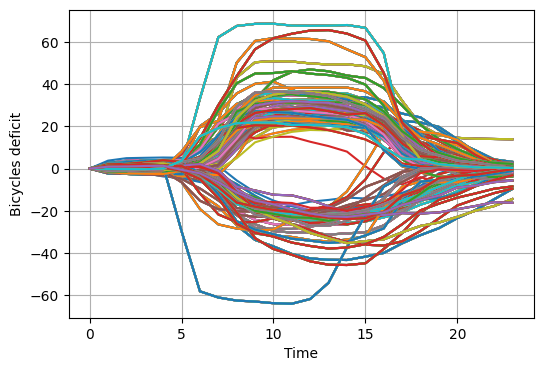

In [79]:
# Viz imbalance for most imbalanced stations

f, ax = plt.subplots(figsize=(6,4))

for i in df_stations_imbalance.index.get_level_values(0):
    x = df_stations.loc[i]['nrides_diff_cum'].copy()

    # Start day with 0 bikes
    x.loc[0] = 0.0
    x = x.sort_index()

    x.plot()

ax.set_xlabel('Time')
ax.set_ylabel('Bicycles deficit')
ax.grid()
plt.show()

In [80]:
# Calculate the maximum imbalance during the day for each station

df_stations_imbalance_pos = df_stations_imbalance[df_stations_imbalance["nrides_diff_cum"]>0]
df_stations_imbalance_neg = df_stations_imbalance[df_stations_imbalance["nrides_diff_cum"]<0]

stations_imbalanced_pos = df_stations_imbalance_pos.groupby(level=0).nrides_diff_cum.max().round().to_frame()
stations_imbalanced_neg = df_stations_imbalance_neg.groupby(level=0).nrides_diff_cum.min().round().to_frame()
stations_imbalanced = pd.concat([stations_imbalanced_pos, stations_imbalanced_neg]).rename(columns={'nrides_diff_cum':'imbalance_max'})
# stations_imbalanced

In [81]:
# Get stations coordinates (GPS float numbers have noise so we cannot aggregate; choose 1st instance)

df_stations_coordinates = df.groupby("start_station_id")\
                            .first()[["start_lat","start_lng", "start_station_name"]]\
                            .rename(columns={'start_lat':'lat', 'start_lng': 'lng',
                                             'start_station_name': 'station_name'})

# df_start = df.groupby("start_station_id").first()[["start_lat","start_lng"]]
# df_end = df.groupby("end_station_id").first()[["start_lat","start_lng"]]
# df_stations_coordinates = pd.concat([df_start, df_end], axis=1, join='outer')

# df_stations = pd.concat([df_stations, df_stations_coordinates], axis=1, join='outer')
# df_stations

# df_stations_coordinates.head()


In [82]:
# Get the imbalanced stations with name, coordinates and maximum imbalance
stations_imbalanced = pd.concat([stations_imbalanced, df_stations_coordinates], axis=1, join='inner')

# Results

In [85]:
stations_imbalanced.sort_values(by='imbalance_max', key=abs, ascending=False)

,imbalance_max,lat,lng,station_name
5470.12,69.0,40.720195,-74.010301,North Moore St & Greenwich St
6822.09,66.0,40.765005,-73.958185,1 Ave & E 68 St
6602.03,-64.0,40.756366,-73.990185,W 41 St & 8 Ave
6584.12,62.0,40.755115,-73.974625,E 47 St & Park Ave
5470.10,51.0,40.720841,-74.009797,Greenwich St & Hubert St
...,...,...,...,...
5105.01,20.0,40.709074,-74.010468,Liberty St & Broadway
7059.08,-20.0,40.772370,-73.990050,West End Ave & W 60 St
5971.08,-20.0,40.735877,-73.982050,E 20 St & 2 Ave
5340.01,20.0,40.716981,-73.956366,N 7 St & Driggs Ave


In [75]:
m = folium.Map(location=[stations_imbalanced.lat.median(),
                         stations_imbalanced.lng.median()],
              zoom_start=10,
              )


n_rows = stations_imbalanced.shape[0]
for i in range(n_rows):

    imbalance = stations_imbalanced.iloc[i]['imbalance_max']
    radius = np.abs(imbalance)/10
    color = 'red' if imbalance<0 else 'green'
    location=(stations_imbalanced.iloc[i]['lat'],
              stations_imbalanced.iloc[i]['lng'])

    folium.CircleMarker(location=location,
                        radius=radius,
                        # weight=0,
                        color=color,
                        # fill=True,
                        # icon=folium.Icon(color=color)
                        ).add_to(m)

m